# Flow cytometry analysis of toxicity of RNA exporter expression from stable genomically integrated transgenes

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/flow_toxicity_stable_cell_line"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

In [4]:
infile = "../preprocessed_data/flow_data/flow_toxicity_stable_cell_line_summary.csv"
df_raw = pd.read_csv(infile, index_col=0)
# df_raw = df_raw.set_index("cell_line")
print(df_raw.shape)
df_raw

(9, 6)


,well,condition,cell_line,replicate,n_events,n_dead+
id,,,,,,
1,C1,Exporter and Cargo,cFH38,1,10000,246
2,D1,Exporter and Cargo,cFH38,2,10000,218
3,E1,Exporter and Cargo,cFH38,3,10000,253
4,C3,Cargo,cFH16,1,10000,262
5,D3,Cargo,cFH16,2,10000,263
6,E3,Cargo,cFH16,3,10000,273
7,C5,Wild-type,HEK293T,1,10000,356
8,D5,Wild-type,HEK293T,2,10000,373
9,E5,Wild-type,HEK293T,3,10000,382


# Preprocess data

In [5]:
# Calculate fraction dead+
df_raw["frac_dead+"] = df_raw["n_dead+"] / df_raw["n_events"]

# Convert to percentage
df_raw["percent_dead+"] = df_raw["frac_dead+"] * 100

In [6]:
df = df_raw.reset_index()

In [7]:
df

,id,well,condition,cell_line,replicate,n_events,n_dead+,frac_dead+,percent_dead+
0,1,C1,Exporter and Cargo,cFH38,1,10000,246,0.0246,2.46
1,2,D1,Exporter and Cargo,cFH38,2,10000,218,0.0218,2.18
2,3,E1,Exporter and Cargo,cFH38,3,10000,253,0.0253,2.53
3,4,C3,Cargo,cFH16,1,10000,262,0.0262,2.62
4,5,D3,Cargo,cFH16,2,10000,263,0.0263,2.63
5,6,E3,Cargo,cFH16,3,10000,273,0.0273,2.73
6,7,C5,Wild-type,HEK293T,1,10000,356,0.0356,3.56
7,8,D5,Wild-type,HEK293T,2,10000,373,0.0373,3.73
8,9,E5,Wild-type,HEK293T,3,10000,382,0.0382,3.82


# Plot abundance of dead+ events

In [8]:
# Set colors

color_exporter = "#b7ade3"
color_no_exporter = "#83888a"
color_heat_killed = "#f5b577"

color_edge = "#010101"

In [9]:
# Set order of samples
cell_lines_ordered = ["cFH38", "cFH16", "HEK293T"]

df["cell_line"] = pd.Categorical(df["cell_line"], categories=cell_lines_ordered, ordered=True)  # convert to categorical with order

df = df.sort_values(by=["cell_line", "replicate"], ascending=True)  # sort values by sample

df.head()

,id,well,condition,cell_line,replicate,n_events,n_dead+,frac_dead+,percent_dead+
0,1,C1,Exporter and Cargo,cFH38,1,10000,246,0.0246,2.46
1,2,D1,Exporter and Cargo,cFH38,2,10000,218,0.0218,2.18
2,3,E1,Exporter and Cargo,cFH38,3,10000,253,0.0253,2.53
3,4,C3,Cargo,cFH16,1,10000,262,0.0262,2.62
4,5,D3,Cargo,cFH16,2,10000,263,0.0263,2.63


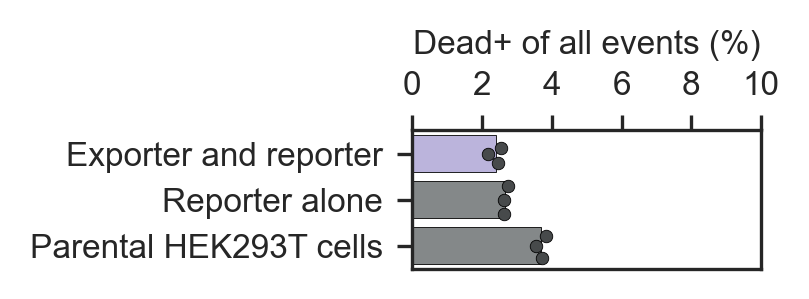

In [10]:
# Pretty plot of all samples (not scaled optimally)

palette = [color_exporter] + [color_no_exporter]*2
# palette = palette[::-1]

fig, ax = plt.subplots(1, 1, figsize=(1.5,0.6))

sns.barplot(ax=ax, data=df,
            y="cell_line",
            x="percent_dead+",
            label="sample",
            palette=palette,
            edgecolor=color_edge,
            linewidth=0.2,
            errorbar=None,
            orient="h")

sns.swarmplot(ax=ax, data=df,
            y="cell_line",
            x="percent_dead+",
            color="#474a4b",
            size=3,
            edgecolor="#010101",
            linewidth=0.2,
            orient="h")

ax.set_xlim(0, 10)
ax.set_xticks([0, 2, 4, 6, 8, 10])

ax.set_xlabel("Dead+ of all events (%)")
ax.set_ylabel("")

ax.set_yticklabels(["Exporter and reporter",
                    "Reporter alone",
                    "Parental HEK293T cells"])

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.get_legend().remove()

save_figure(fig, "swarmplot_dead")